# Searching for Locations Within an Area Using SpatiaLite

As as spatial database, *SpatiaLite* supports geospatial queries, such as identifying locations that exist *within* a particular spatially defined area.

This notebook provides some simple examples of searching for locations of establishments rated by the UK Food Standards Agency.

The search context is based on three *SpatiaLite* tables:

- a table containing shapefiles specifying the area the establishments should be located within;
- a spatial index table corresponding to the shapefile table that contains bounding box limits for shapefile areas to allow a preliminary quick search;
- a table containing point locations, some of which hope to dientify as being located within the specified area.

In [1]:
import oifsa, sqlite3

The boundary files we'll use come from the Ordnance Survey *BoundaryLine* product. In particular, we'll be searching within parish boundaries.

In [2]:
dbname='adminboundaries.db'
conn = sqlite3.connect(dbname)

In [3]:
#Handy utility function
def droptable(conn,table):
    cursor = conn.cursor()
    cursor.execute('''DROP TABLE IF EXISTS {}'''.format(table))
    conn.commit()

## Point Location Data

The point location data is loaded from a data file published by the Food Standards Agency.

In [4]:
#Name oftable for the point location data
table = 'foodratings'
#droptable(conn,table)

In [ ]:
#wight /via http://ratings.food.gov.uk/open-data/en-GB
url='http://ratings.food.gov.uk/OpenDataFiles/FHRS867en-GB.xml'

#Grab the data using the ouseful data supply food-gov-uk package
# https://github.com/ouseful-datasupply/food_gov_uk
oifsa.save_fsa_data(url, conn, table, delay=1)

*Note that the foodgov co-ordinates seem to be postcode centroid locations, or some other area based value, and as such are not very accurate.*

*It would perhaps be better to use OpenStreetMap to re-geocode the locations from provided addresses?*

Modify the ratings table with a column that allows for the storage of point location data as a *Geometry* and use the latitide and longitude columns as the basis for the points. Use EPSG / CRSID 4326 ([WGS64](http://spatialreference.org/ref/epsg/wgs-84/)) as the projection.

In [6]:
addPointFromLatLon ='''
BEGIN;
SELECT AddGeometryColumn('{table}', 'Geometry', 4326, 'POINT', 2);
UPDATE {table} SET Geometry = GeomFromText('POINT('||"Longitude"||' '||"Latitude"||')',4326);
COMMIT;
'''.format(table=table)

with open("addpointFromLatLon.sql", "w") as sqlfile:
    sqlfile.write(addPointFromLatLon)
    
!cat addpointFromLatLon.sql


BEGIN;
SELECT AddGeometryColumn('foodratings', 'Geometry', 4326, 'POINT', 2);
UPDATE foodratings SET Geometry = GeomFromText('POINT('||"Longitude"||' '||"Latitude"||')',4326);
COMMIT;


In [7]:
#Add the column to the table
! spatialite adminboundaries.db ".read addpointFromLatLon.sql utf-8"

SpatiaLite version ..: 4.3.0a	Supported Extensions:
	- 'VirtualShape'	[direct Shapefile access]
	- 'VirtualDbf'		[direct DBF access]
	- 'VirtualXL'		[direct XLS access]
	- 'VirtualText'		[direct CSV/TXT access]
	- 'VirtualNetwork'	[Dijkstra shortest path]
	- 'RTree'		[Spatial Index - R*Tree]
	- 'MbrCache'		[Spatial Index - MBR cache]
	- 'VirtualSpatialIndex'	[R*Tree metahandler]
	- 'VirtualElementary'	[ElemGeoms metahandler]
	- 'VirtualXPath'	[XML Path Language - XPath]
	- 'VirtualFDO'		[FDO-OGR interoperability]
	- 'VirtualGPKG'	[OGC GeoPackage interoperability]
	- 'VirtualBBox'		[BoundingBox tables]
	- 'SpatiaLite'		[Spatial SQL - OGC]
PROJ.4 version ......: Rel. 5.1.0, June 1st, 2018
GEOS version ........: 3.6.2-CAPI-1.10.2 4d2925d6
TARGET CPU ..........: x86_64-apple-darwin17.3.0
AddGeometryColumn: "duplicate column name: Geometry"
0



The original shapefile uses the OSGB projection (CRSID 27700), so let's also create a point geometry column using that projection. We can use the `ST_Transform()` *SpatiaLite* function to transform the WGS84 (EPSG:4326) tagged `Geometry` point column to create the new column.

In [8]:
osgbfromlatlon='''
BEGIN;
SELECT AddGeometryColumn('{table}', 'osgb', 27700, 'POINT', 2);
UPDATE {table} SET osgb = ST_Transform(Geometry, 27700);
COMMIT;
'''.format(table=table)

with open("osgbfromlatlon.sql", "w") as sqlfile:
    sqlfile.write(osgbfromlatlon)
!cat osgbfromlatlon.sql


BEGIN;
SELECT AddGeometryColumn('foodratings', 'osgb', 27700, 'POINT', 2);
UPDATE foodratings SET osgb = ST_Transform(Geometry, 27700);
COMMIT;


In [9]:
#Create the new column and run the transformation to populate it
! spatialite adminboundaries.db ".read osgbfromlatlon.sql utf-8"

SpatiaLite version ..: 4.3.0a	Supported Extensions:
	- 'VirtualShape'	[direct Shapefile access]
	- 'VirtualDbf'		[direct DBF access]
	- 'VirtualXL'		[direct XLS access]
	- 'VirtualText'		[direct CSV/TXT access]
	- 'VirtualNetwork'	[Dijkstra shortest path]
	- 'RTree'		[Spatial Index - R*Tree]
	- 'MbrCache'		[Spatial Index - MBR cache]
	- 'VirtualSpatialIndex'	[R*Tree metahandler]
	- 'VirtualElementary'	[ElemGeoms metahandler]
	- 'VirtualXPath'	[XML Path Language - XPath]
	- 'VirtualFDO'		[FDO-OGR interoperability]
	- 'VirtualGPKG'	[OGC GeoPackage interoperability]
	- 'VirtualBBox'		[BoundingBox tables]
	- 'SpatiaLite'		[Spatial SQL - OGC]
PROJ.4 version ......: Rel. 5.1.0, June 1st, 2018
GEOS version ........: 3.6.2-CAPI-1.10.2 4d2925d6
TARGET CPU ..........: x86_64-apple-darwin17.3.0
AddGeometryColumn: "duplicate column name: osgb"
0



Create a spatial index on the boundary data table to speed up queries.

In [10]:
! spatialite adminboundaries.db "SELECT CreateSpatialIndex('parish_region', 'Geometry');"

SpatiaLite version ..: 4.3.0a	Supported Extensions:
	- 'VirtualShape'	[direct Shapefile access]
	- 'VirtualDbf'		[direct DBF access]
	- 'VirtualXL'		[direct XLS access]
	- 'VirtualText'		[direct CSV/TXT access]
	- 'VirtualNetwork'	[Dijkstra shortest path]
	- 'RTree'		[Spatial Index - R*Tree]
	- 'MbrCache'		[Spatial Index - MBR cache]
	- 'VirtualSpatialIndex'	[R*Tree metahandler]
	- 'VirtualElementary'	[ElemGeoms metahandler]
	- 'VirtualXPath'	[XML Path Language - XPath]
	- 'VirtualFDO'		[FDO-OGR interoperability]
	- 'VirtualGPKG'	[OGC GeoPackage interoperability]
	- 'VirtualBBox'		[BoundingBox tables]
	- 'SpatiaLite'		[Spatial SQL - OGC]
PROJ.4 version ......: Rel. 5.1.0, June 1st, 2018
GEOS version ........: 3.6.2-CAPI-1.10.2 4d2925d6
TARGET CPU ..........: x86_64-apple-darwin17.3.0
CreateSpatialIndex() error: either "parish_region"."Geometry" isn't a Geometry column or a SpatialIndex is already defined
0


The index table is created as `idx_TABLENAME_COLUMN`, in this case `idx_parish_region_geometry`.

Let's have a quick look at it.

In [44]:
import requests, json
#import pandas as pd
import geopandas as gpd
from shapely.geometry import shape 


def query_datasette_api(q,db_url = "http://localhost:8001/adminboundaries.json",
                        dataframe=False, geojsoncol=None):
    ''' Simple query to datasette endpoint. Return response as a dict or pandas dataframe. '''
    params = {'sql': q}

    r = requests.get(db_url, params=params)
    jdata=r.json()
    if dataframe:
        df=gpd.GeoDataFrame(jdata['rows'])
        df.columns = jdata['columns']
        for c in df.columns:
            #Need a better way to identify geo columns?
            #Also, this should really be a geopandas dataframe, with the json column as a geometry column
            if c.startswith('AsGeoJSON'):
                df[c]=df[c].apply(json.loads)
                cn=c.replace('AsGeoJSON(','').replace(')','')
                df[cn]=df[c].apply(shape)
        return df
    
    #Need a better way to identify geo columns?
    ix = [jdata['columns'].index(c) for c in jdata['columns'] if c.startswith('AsGeoJSON')]
    for i in ix:
        for i2 in range(len(jdata['rows'])):
            jdata['rows'][i2][i]=json.loads(jdata['rows'][i2][i])

    geojsoncol  = geojsoncol if geojsoncol and geojsoncol.startswith('AsGeoJSON') else 'AsGeoJSON({})'.format(geojsoncol)
    if geojsoncol and geojsoncol in jdata['columns']:
        return jdata['rows'][jdata['columns'].index(geojsoncol)][0]
    return jdata

In [36]:
query_datasette_api("SELECT * FROM idx_parish_region_geometry LIMIT 2",
                    "http://localhost:8003/adminboundaries.json")

{'database': 'adminboundaries',
 'rows': [[9448, 135524.6875, 140380.125, 21392.095703125, 25377.1953125],
  [9449, 137675.6875, 145051.609375, 22622.400390625, 28994.603515625]],
 'truncated': False,
 'columns': ['pkid', 'xmin', 'xmax', 'ymin', 'ymax'],
 'query': {'sql': 'SELECT * FROM idx_parish_region_geometry LIMIT 2',
  'params': {}},
 'query_ms': 0.4799365997314453}

Let's also just have a quick look at a query on the `foodratings` table:

In [16]:
q='''
SELECT FHRSID, BusinessName, BusinessType, BusinessTypeID, RatingValue, AsGeoJSON(Geometry)
    FROM foodratings WHERE Geometry IS NOT NULL LIMIT 2;
'''

query_datasette_api(q,"http://localhost:8003/adminboundaries.json", True)

,FHRSID,BusinessName,BusinessType,BusinessTypeID,RatingValue,AsGeoJSON(Geometry),Geometry
0,1049392,135A Hunnyhill,Retailers - other,4613,AwaitingInspection,"{'type': 'Point', 'coordinates': [-1.299703001...",POINT (-1.29970300197601 50.7066879272461)
1,1051980,20 Esplanade,Takeaway/sandwich shop,7844,AwaitingInspection,"{'type': 'Point', 'coordinates': [-1.158509016...",POINT (-1.15850901603699 50.7319946289063)


## Creating Spatial Queries

One of the advantages of using a geo-sensitive database such as *SpatiaLite* is that it allows us to run spatial queries. For example, the *SpatialLite* `within(POINT, REGION)` function allows us to check whether a point lays within a particular spatial boundary (I'm not sure if the function is inclusive or exclusive, which is to say whether a point is *within* an area if it is on the boundary of the area.)

We can naively run a query that returns the points listed in one table that are contained within a shapefile retrieved from another table. For example, something like:

```sql
SELECT BusinessName, AsGeoJSON(foodratings.Geometry)
    FROM foodratings, parish_region 
    WHERE parish_region.NAME LIKE '%Arreton%' AND foodratings.Geometry NOT NULL
          AND within(foodratings.Geometry, parish_region.wgs84) ;
```

However, such queries can take a long time to process. Instead, we might run a query against the shapefile index to locate points with the bounding box that encloses the shapefile:

```sql
SELECT FHRSID, p.wgs84, f.Geometry, f.BusinessName, f.BusinessType FROM 
         (SELECT FHRSID, Geometry, X(osgb) x, Y(osgb) y, BusinessName, BusinessType
              FROM foodratings WHERE Geometry NOT NULL) f,
         parish_region p, idx_parish_region_geometry i
         WHERE p.NAME LIKE '%Arreton%' AND p.pk_uid= i.pkid AND 
             i.xmin < f.x and i.xmax > f.x and i.ymin < f.y and i.ymax > f.y) fr;
```

and then tighten up the query around those efficiently selected points:

In [17]:
q='''
SELECT BusinessName, BusinessType, AsGeoJSON(Geometry) FROM 
    (SELECT FHRSID, p.wgs84, f.Geometry, f.BusinessName, f.BusinessType FROM 
         (SELECT FHRSID, Geometry, X(osgb) x, Y(osgb) y, BusinessName, BusinessType
              FROM foodratings WHERE Geometry NOT NULL) f ,
         parish_region p, idx_parish_region_geometry i
         WHERE p.NAME LIKE '%Arreton%' AND p.pk_uid= i.pkid AND 
             i.xmin < f.x and i.xmax > f.x and i.ymin < f.y and i.ymax > f.y) fr
   WHERE within(Geometry, wgs84) ;
'''

In [22]:
results = query_datasette_api(q,"http://localhost:8003/adminboundaries.json", True)
results.head(3)

,BusinessName,BusinessType,AsGeoJSON(Geometry),Geometry
0,Amazon World,Restaurant/Cafe/Canteen,"{'type': 'Point', 'coordinates': [-1.218829035...",POINT (-1.21882903575897 50.6552581787109)
1,Arreton Community Centre,Other catering premises,"{'type': 'Point', 'coordinates': [-1.241533041...",POINT (-1.24153304100037 50.67551422119139)
2,Arreton Manor Guest House,Hotel/bed & breakfast/guest house,"{'type': 'Point', 'coordinates': [-1.246361017...",POINT (-1.24636101722717 50.6780624389648)


We can now display those points on a map:

In [19]:
import folium
import html
from folium.plugins import MarkerCluster

#Hacky for now
#Coords are wrong way round?
center=results['Geometry'][0].coords[0][::-1]

m=folium.Map( location=center, zoom_start=12)

mc = MarkerCluster()

for ix,row in results.iterrows():
    mc.add_child(folium.Marker(location=row['Geometry'].coords[0][::-1],
                               popup='{}<br/>{}'.format(html.escape(row['BusinessName']),
                                                        html.escape(row['BusinessType']))))

m.add_child(mc)
m

For small areas, using the marker cluster may not be appropriate. On the one hand, the clusterer is quite aggressive and may cluster nearby items inappropriately. On the other, where points are geocoded as postcode centroids, the marker cluster does provide an advantage becuase it allows us to split out multiple points that are colocated, which hides all but the last rendered marker from the user if the marker cluster is not used.

To be able to see multiple co-located points, we need to use map extension that allows us to explode colacated points, or add a small random perturbation to each marker so that it is plotted uniquely:

In [53]:
m=folium.Map(location=center, zoom_start=12)

import numpy as np

for ix,row in results.iterrows():
    loc=list(row['Geometry'].coords[0][::-1])
    loc[0]=loc[0]+np.random.uniform(0.001, 10**(-20))-0.0005
    loc[1]=loc[1]+np.random.uniform(0.001, 10**(-20))-0.0005

    folium.Marker(loc, popup='{}<br/>{}'.format(html.escape(row['BusinessName']),
                                                html.escape(row['BusinessType']))).add_to(m)
m

Another approach might be to try to geocode different addresses more accurately than their postcode centroid.

To check that the markers are indeed bounded by the search area, we can add the boundary to the map as well as the points that supposedly lay within it.

In [38]:
def get_geojson(region_type, region, county=None, code=None,
                col='wgs84',db_url = "http://localhost:8001/adminboundaries.json",
                dataframe=False, geojsoncol=None):
    ''' Return boundaries of a given name within an optional given county. '''
    
    q='SELECT AsGeoJSON({col}) FROM {table} WHERE name LIKE "%{region}%"'.format(col=col,table=region_type,region=region)
    
    if county is not None: q='{} AND FILE_NAME LIKE "%{}%"'.format(q, county)
    if code is not None: q='{} AND CODE LIKE "%{}%"'.format(q, code)
        
    return query_datasette_api(q, db_url=db_url, dataframe=dataframe, geojsoncol=geojsoncol)


In [54]:
#Get the boundaryline
geojson = get_geojson('parish_region', 'Arreton', geojsoncol='wgs84',
                      db_url = "http://localhost:8003/adminboundaries.json")

#Add it to the map
folium.GeoJson(geojson, name='geojson').add_to(m)
                      
m

## Enhancing Point Location Data Using OpenStreetMap

Locations generated as postcode centroids are not very accurate. To improve the location data for particular points, we could use the OSM geolocation API to get more exact location data from the geocoded address.

The `osmnx` package provides a convenient utility function for this:

In [55]:
import osmnx
osmnx.pois_from_address("Dairyman's, Arreton, Isle of Wight",0.1)

,amenity,element_type,geometry,name,osmid
11248231,pub,node,POINT (-1.2463103 50.6779437),Dairymans Daughter,11248231


As well as geocoding addresses, the OpenStreetMap API also allows us to search for poitns of interest (POIs) *within* a particular boundary directly. In addition, we can limit the search using particular [amenity tags](https://taginfo.openstreetmap.org/keys/amenity#values). Once again, there is an `osmnx` utulity function to help us with this.

First, let's get a `shapely` representation of the area we want to search within:

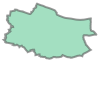

In [62]:
gj=get_geojson('parish_region', 'arreton', geojsoncol='wgs84',
               db_url = "http://localhost:8003/adminboundaries.json")

shp = shape( gj )
shp

We can now search OpenStreetMap for POIs associated with particular amemity tags within that area:

In [67]:
def get_osm_amenity_nodes(shp, tags=None):
    ''' Simplify OSM amenity search to just return nodes. '''
    
    tags = tags if tags is None or isinstance(tags, list) else [tags]
    items = osmnx.osm_poi_download(shp,tags)
    return [item for item in items['elements'] if item['type']=='node']

In [68]:
get_osm_amenity_nodes(shp,'pub')

[{'type': 'node',
  'id': 11248229,
  'lat': 50.6772199,
  'lon': -1.2454996,
  'tags': {'addr:city': 'Arreton',
   'addr:postcode': 'PO30 3AA',
   'addr:street': 'Main Road',
   'amenity': 'pub',
   'name': 'The White Lion',
   'phone': '+44 1983 528479',
   'website': 'http://www.whitelionarreton.com'}},
 {'type': 'node',
  'id': 11248231,
  'lat': 50.6779437,
  'lon': -1.2463103,
  'tags': {'amenity': 'pub', 'name': 'Dairymans Daughter'}},
 {'type': 'node',
  'id': 11604647,
  'lat': 50.6533199,
  'lon': -1.2770359,
  'tags': {'amenity': 'pub', 'name': 'Rookley Inn'}},
 {'type': 'node', 'id': 1999008018, 'lat': 50.6543751, 'lon': -1.2230635},
 {'type': 'node', 'id': 1999008023, 'lat': 50.6544119, 'lon': -1.2228529},
 {'type': 'node', 'id': 1999008026, 'lat': 50.654452, 'lon': -1.2228998},
 {'type': 'node', 'id': 1999008029, 'lat': 50.6544766, 'lon': -1.2231822},
 {'type': 'node', 'id': 1999008032, 'lat': 50.6544869, 'lon': -1.2226933},
 {'type': 'node', 'id': 1999008035, 'lat': 50.6